In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
N = 200 # number of prompts
embedding_dim = 16 # dimension of the "prompt-response" embedding

# Random embeddings for "prompt-response" pairs
# shape: (N, 2, embed_dim) -> For each prompt, we have 2 responses
mock_data = torch.randn(N, 2, embedding_dim)

# Random labels: 1 if the first response is preferred, else 0
# shape: (N,)
mock_labels = torch.randint(low=0, high=2, size=(N,))

In [6]:
#define a simple feedforward neural network named FeedForwarRewardModel
class FeedForwardRewardModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardRewardModel, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layer(x).squeeze(-1)

In [39]:
#define a loss function named reward_loss
def pairwise_ranking_loss(reward_w, reward_l):
    """
    reward_w: predicted reward for the preferred (winning) response
    reward_l: predicted reward for the less preferred (losing) response
    
    Returns the average pairwise ranking loss from the paper:
    L = -log( sigmoid( reward_w - reward_l ) )
    """
    return -torch.log(torch.sigmoid(reward_w - reward_l) + 1e-12).mean()

In [ ]:
#define a model
reward_model = FeedForwardRewardModel(embedding_dim)
#adam 梯度下降
optimizer = optim.Adam(reward_model.parameters(), lr=1e-3)
num_epochs = 200
losses = []

# Training loop
for epoch in range(num_epochs):
    #shuffle the data
    perm = torch.randperm(N)
    mock_data = mock_data[perm]
    mock_labels = mock_labels[perm]

    epoch_loss = 0
    batch_size = 32

    for i in range(0, N, batch_size):
        #optimizer.zero_grad()
        batch_data = mock_data[i:i+batch_size]
        batch_labels = mock_labels[i:i+batch_size]

        # Separate the "winning" and "losing" pairs based on label
        # If label=1 => first is preferred; else second is preferred
        resp_winning  = torch.zeros_like(batch_data[:,0,:])
        resp_losing   = torch.zeros_like(batch_data[:,0,:])
        
        # Indices where first response is preferred
        idx_first_win = (batch_labels == 1)
        # Indices where second response is preferred
        idx_second_win = (batch_labels == 0)

        resp_winning[idx_first_win] = batch_data[idx_first_win, 0, :]
        resp_winning[idx_second_win] = batch_data[idx_second_win, 1, :]

        resp_losing[idx_first_win] = batch_data[idx_first_win, 1, :]
        resp_losing[idx_second_win] = batch_data[idx_second_win, 0, :]

        # feed the winning/lossing responses to the reward model
        reward_w = reward_model(resp_winning)
        reward_l = reward_model(resp_losing)
        
        # Compute the pairwise ranking loss
        loss = pairwise_ranking_loss(reward_w, reward_l)

        # Backpropagation
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / (N // batch_size)
    losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")    

Epoch 1/200, Loss: 0.8287
Epoch 2/200, Loss: 0.7980
Epoch 3/200, Loss: 0.8030
Epoch 4/200, Loss: 0.7797
Epoch 5/200, Loss: 0.7757
Epoch 6/200, Loss: 0.7551
Epoch 7/200, Loss: 0.7540
Epoch 8/200, Loss: 0.7551
Epoch 9/200, Loss: 0.7474
Epoch 10/200, Loss: 0.7389
Epoch 11/200, Loss: 0.7326
Epoch 12/200, Loss: 0.7285
Epoch 13/200, Loss: 0.7101
Epoch 14/200, Loss: 0.6749
Epoch 15/200, Loss: 0.6856
Epoch 16/200, Loss: 0.6819
Epoch 17/200, Loss: 0.6633
Epoch 18/200, Loss: 0.6612
Epoch 19/200, Loss: 0.6274
Epoch 20/200, Loss: 0.6351
Epoch 21/200, Loss: 0.6694
Epoch 22/200, Loss: 0.6009
Epoch 23/200, Loss: 0.5853
Epoch 24/200, Loss: 0.5827
Epoch 25/200, Loss: 0.5818
Epoch 26/200, Loss: 0.5742
Epoch 27/200, Loss: 0.5314
Epoch 28/200, Loss: 0.5193
Epoch 29/200, Loss: 0.5170
Epoch 30/200, Loss: 0.5357
Epoch 31/200, Loss: 0.5052
Epoch 32/200, Loss: 0.4948
Epoch 33/200, Loss: 0.4878
Epoch 34/200, Loss: 0.4946
Epoch 35/200, Loss: 0.4656
Epoch 36/200, Loss: 0.4669
Epoch 37/200, Loss: 0.4218
Epoch 38/2

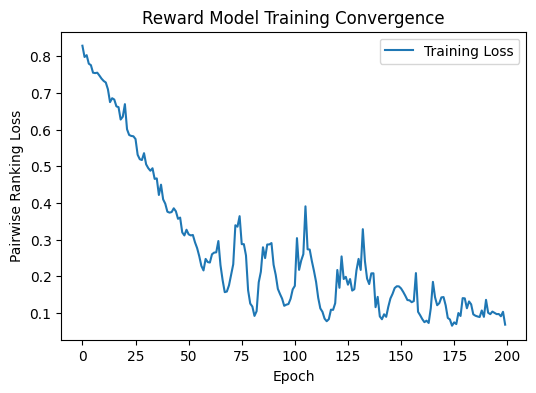

In [46]:
import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(6,4))
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Pairwise Ranking Loss')
plt.title('Reward Model Training Convergence')
plt.legend()
plt.show()

In [38]:
perm = torch.randperm(3)
print(torch.max(perm))
print("Data is ", mock_data[perm,0,:])
#define a 16 * 1 matrix
matrix = torch.randn(16,1)
print("Matrix is ", matrix)
print("Matrix squeeze is ", matrix.squeeze(-1))

print(mock_labels.shape)
print("Labels are",mock_labels[:10])
resp_winning  = torch.zeros_like(mock_data[:,0,:])
#resp_losing   = torch.zeros_like(mock_data[prem,0,:])
print("resp_winning",resp_winning.shape)
#print("resp_losing",resp_losing)batch_size = 32
batch_size = 32
print(N/batch_size, N//batch_size)

tensor(2)
Data is  tensor([[ 1.5054,  1.3152, -0.3946,  0.6974, -0.9081, -0.9323,  0.5477,  1.1119,
         -1.7775,  1.4385, -1.2112, -1.1711,  0.5734, -2.0453,  0.9068,  0.5225],
        [-0.2186, -0.2938, -0.5188, -0.4824,  0.8768, -2.3168, -0.3871,  0.3541,
          0.6172,  1.4919, -0.1136,  0.7681, -0.0692,  2.5009, -1.3068,  1.1655],
        [ 0.5892,  0.0345,  0.6274,  1.4231, -0.8440, -0.0366,  0.1711, -0.0286,
          0.5349, -0.1449, -1.2019, -1.1839, -0.1742, -0.4003, -0.3020, -0.4900]])
Matrix is  tensor([[-1.0100],
        [-0.1663],
        [ 0.0096],
        [-0.6668],
        [ 0.4940],
        [-0.1946],
        [-0.1662],
        [ 0.0872],
        [ 0.2128],
        [-1.0357],
        [ 1.7439],
        [ 0.9268],
        [ 1.0526],
        [ 1.3896],
        [-0.4084],
        [-1.2303]])
Matrix squeeze is  tensor([-1.0100, -0.1663,  0.0096, -0.6668,  0.4940, -0.1946, -0.1662,  0.0872,
         0.2128, -1.0357,  1.7439,  0.9268,  1.0526,  1.3896, -0.4084, -1.23